In [1]:
import requests
from requests.auth import HTTPBasicAuth
from urllib.parse import urlencode
import datetime as dt

import pandas as pd
import geopandas

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

In [160]:
# Run for local database
HOST = 'http://localhost'
auth = None

In [2]:
# Run for hosted database
HOST = 'https://esida.informatik.haw-hamburg.de'
auth = HTTPBasicAuth('esida', 'opendata22')

# Get Shapes from database

In [3]:
# Parameters:
# - type=region|district (optional)
# - wkt (optional, returns Geometry)
q = {
    'type': 'region',
    'wkt': True
}
d = requests.get(f"{HOST}/api/v1/shapes?{urlencode(q)}", auth=auth).json()

# DataFrame
regions_gdf = geopandas.GeoDataFrame(d['data'])
if q['wkt']:
    regions_gdf['geometry'] = geopandas.GeoSeries.from_wkt(regions_gdf['wkt'])
    regions_gdf = regions_gdf.drop(columns=['wkt'])

In [13]:
regions = dict(zip(regions_gdf.id, regions_gdf.name))
region_shapes = dict(zip(regions_gdf.id, regions_gdf.geometry))

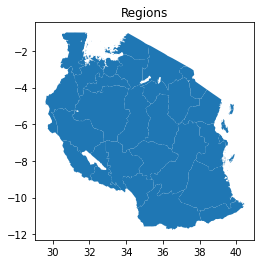

In [5]:
regions_gdf.plot()
plt.title('Regions')
plt.show()

In [36]:
def get_geom_for_id(shape_id):
    if shape_id in region_shapes:
        return region_shapes[shape_id]
    return None

# Population density

In [35]:
parameter_id = 'worldpop_popd'
q = {
    'start_date': '2020', # optional
    'end_date': '2020' # optional
}
d = requests.get(f"{HOST}/api/v1/parameter/{parameter_id}?{urlencode(q)}", auth=auth).json()
popd_df = pd.DataFrame(d['data'])
shape_ids = param_df['shape_id'].unique()

In [38]:
# Add geomentries and create pandas data frame for plotting
popd_df['geometry'] = popd_df['shape_id'].apply(get_geom_for_id)
popd_gdf = geopandas.GeoDataFrame(popd_df)

<AxesSubplot:>

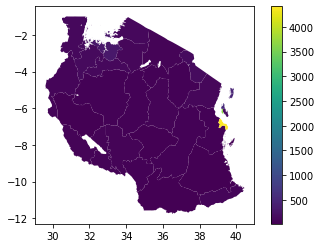

In [49]:
popd_gdf[~popd_gdf['geometry'].isna()].plot(column='worldpop_popd_mean', legend=True)

<AxesSubplot:>

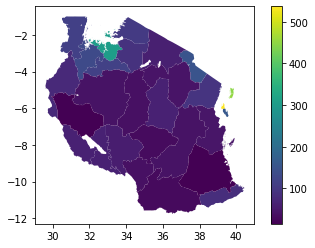

In [58]:
popd_gdf[~popd_gdf['geometry'].isna()].sort_values('worldpop_popd_mean', ascending=False)[2:].plot(column='worldpop_popd_mean', legend=True)

# Load Transport related POIs

In [6]:
parameter_id = 'geofabrik_transport'
q = {}
d = requests.get(f"{HOST}/api/v1/parameter/{parameter_id}?{urlencode(q)}", auth=auth).json()
param_df = pd.DataFrame(d['data'])
shape_ids = param_df['shape_id'].unique()

In [21]:
param_df['geometry'] = param_df['shape_id'].apply(get_geom_for_id)
param_gdf = geopandas.GeoDataFrame(param_df)

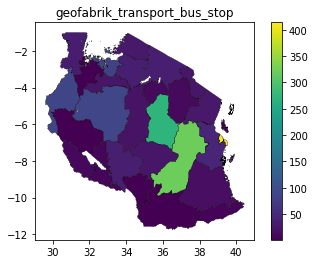

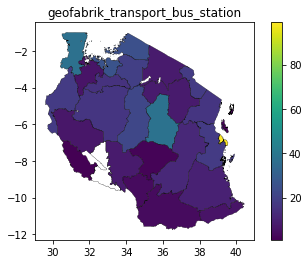

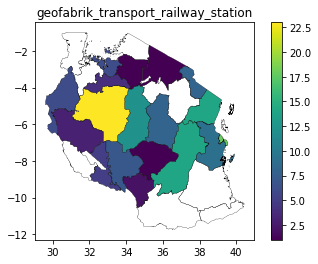

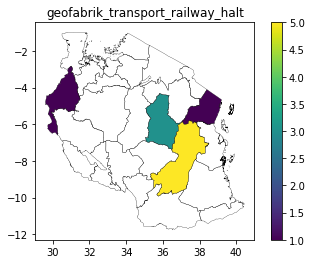

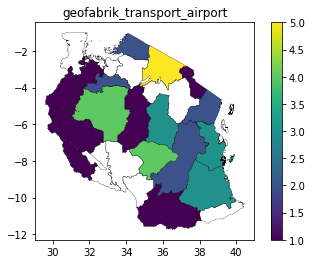

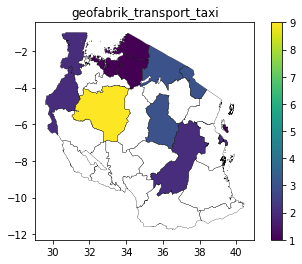

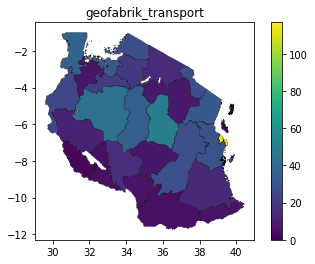

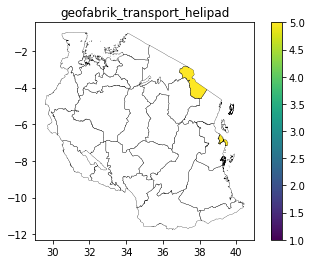

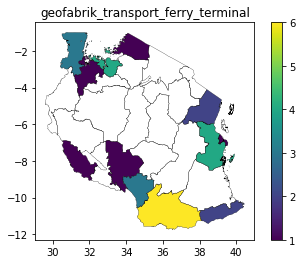

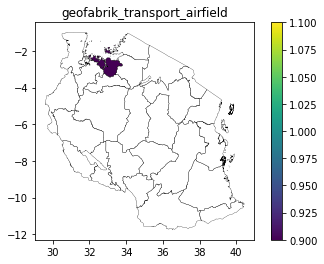

In [34]:
for field in d['fields']:
    ax = param_gdf.plot(column=field, legend=True)
    regions_gdf.plot(ax=ax, facecolor="none", edgecolor='black', lw=0.25)
    plt.title(field)
    plt.show()

# Correlation between popd and pois?

In [74]:
df1 = popd_df[['worldpop_popd_mean', 'shape_id']]
df2 = param_gdf[[
    'geofabrik_transport', 
    'geofabrik_transport_airport', 
    'geofabrik_transport_bus_station', 
    'geofabrik_transport_railway_station',
    
    'shape_id']]

df3 = df1.merge(df2, how='inner', on='shape_id')

In [75]:
corr = df3.corr()
corr.style.background_gradient(cmap='coolwarm')

,worldpop_popd_mean,shape_id,geofabrik_transport,geofabrik_transport_airport,geofabrik_transport_bus_station,geofabrik_transport_railway_station
worldpop_popd_mean,1.000000,0.064351,0.218155,-0.267557,0.213306,0.082843
shape_id,0.064351,1.000000,-0.379477,-0.413108,-0.373393,-0.418282
geofabrik_transport,0.218155,-0.379477,1.000000,0.384800,0.969648,0.759518
geofabrik_transport_airport,-0.267557,-0.413108,0.384800,1.000000,0.246738,0.211411
geofabrik_transport_bus_station,0.213306,-0.373393,0.969648,0.246738,1.000000,0.582396
geofabrik_transport_railway_station,0.082843,-0.418282,0.759518,0.211411,0.582396,1.000000
